In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
from scipy.misc import toimage
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
import PIL
import sys
import seaborn as sns
import sklearn.metrics
import pickle

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
torch.cuda.set_device(1)
x=torch.Tensor(5,3)
print(x.cuda())

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  1.4013e-45,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00, -1.6339e-36],
        [ 4.5590e-41, -4.7332e-05,  3.0822e-41],
        [ 0.0000e+00,  0.0000e+00,  1.0965e-38]], device='cuda:1')


In [5]:
print(torch.__version__)

1.1.0a0+828a6a3


In [23]:
data_aug = True 
early_stopping = True

In [24]:
data_aug_transforms = []

if data_aug == True:

    data_aug_transforms = [
        transforms.RandomCrop((32,32), padding=4),
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomRotation(15),
#         transforms.RandomAffine(degrees=0, translate=(.3,.7)),
#         transforms.ColorJitter(
#                 brightness=float(0.1*np.random.rand(1)),
#                 contrast=float(0.1*np.random.rand(1)),
#                 saturation=float(0.1*np.random.rand(1)),
#                 hue=float(0.1*np.random.rand(1))),
#         
#         transforms.Resize((224,224)),
        transforms.ColorJitter(hue=.25, saturation=.25),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
        transforms.RandomGrayscale(p=0.1)
                    ]

In [25]:
norm_transform = transforms.Compose(data_aug_transforms+[transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                     ])
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                     ])

In [26]:
# cifar_dataset = torchvision.datasets.CIFAR10(root='dataset/',
#                                            train=True,
#                                            transform=norm_transform,
#                                            download=False)

# test_dataset = torchvision.datasets.CIFAR10(root='dataset/',
#                                           train=False,
#                                           transform=test_transform)

In [27]:
cifar_dataset = torchvision.datasets.CIFAR10(root='../dataset/',
                                           train=True,
                                           transform=norm_transform,
                                           download=False)

test_dataset = torchvision.datasets.CIFAR10(root='../dataset/',
                                          train=False,
                                          transform=test_transform)

In [28]:
n = 2
np.random.seed(n)
torch.cuda.manual_seed_all(n)
torch.manual_seed(n)

In [29]:
def weights_init(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight.data, mean=0.0, std=1e-3)
        m.bias.data.fill_(0.0)
        
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_normal_(m.weight.data) 
        m.bias.data.fill_(0.0)

def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: %s'%device)

Using device: cuda


In [32]:
mask = list(range(num_training))
train_dataset = torch.utils.data.Subset(cifar_dataset, mask)
mask = list(range(num_training, num_training + num_validation))
val_dataset = torch.utils.data.Subset(cifar_dataset, mask)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [38]:
class ConvNet(nn.Module):
    def __init__(self, input_size, hidden_layers, num_classes, dropout):
        super(ConvNet, self).__init__()
            
        self.conv = nn.Sequential(
                    nn.Conv2d(in_channels=input_size, out_channels=hidden_layers[0], kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(hidden_layers[0]),
                    nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.ReLU(),
                    nn.Dropout2d(dropout),

                    nn.Conv2d(in_channels=hidden_layers[0], out_channels=hidden_layers[1], kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(hidden_layers[1]),
                    nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.ReLU(),
                    nn.Dropout2d(dropout),

                    nn.Conv2d(in_channels=hidden_layers[1], out_channels=hidden_layers[2], kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(hidden_layers[2]),
                    nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.ReLU(),
                    nn.Dropout2d(dropout),

                    nn.Conv2d(in_channels=hidden_layers[2], out_channels=hidden_layers[3], kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(hidden_layers[3]),
                    nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.ReLU(),
                    nn.Dropout2d(dropout),

                    nn.Conv2d(in_channels=hidden_layers[3], out_channels=hidden_layers[4], kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(hidden_layers[4]),
                    nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.ReLU(),
                    nn.Dropout2d(dropout)    )

        self.fc = nn.Sequential(
                    nn.Linear(hidden_layers[4], hidden_layers[5]),
                    nn.BatchNorm1d(hidden_layers[5]),
                    nn.ReLU(),

                    nn.Linear(hidden_layers[5], num_classes)
                        )

    def forward(self, x):
        
        x = self.conv(x)
        x = x.squeeze()
        out = self.fc(x)
        
        return out

In [39]:
def PrintModelSize(model, disp=True):
    model_sz = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("Number of trainable parameters = ",model_sz)
    return model_sz

In [95]:
def VisualizeFilter(model, superTitle):
    
    tensor = torch.ones(model.conv[0].weight.data.size())
    tensor = model.conv[0].weight.clone().detach().requires_grad_(False)
    tensor = tensor.cpu().data.numpy()
    
    t_max = np.amax(tensor)
    t_min = np.amin(tensor)

    tensor = (tensor - t_min) / (t_max - t_min) 

    num_cols = 16
    num_kernels = tensor.shape[0]
    num_rows = 1+ num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols,num_rows))
    fig.set_facecolor("black")

    for i in range(tensor.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        ax1.imshow(tensor[i],)
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
    
    fig.suptitle(superTitle, color='white')
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

In [85]:
input_size = 3
num_classes = 10
hidden_size = [128, 512, 512, 512, 512, 512]
num_epochs = 2
batch_size = 200
learning_rate = 2e-3
learning_rate_decay = 0.95
reg=0.001
num_training= 49000
num_validation =1000

In [86]:
dropoutVals = [i/10 for i in range(1,10)]
dropoutVals = [.1,.2,.3]

In [89]:
listOfAllLosses = []
listOfAllValAccs = []

testAcc = []
trainAcc = []

for dropout in dropoutVals :

    print("######################################################################")
    print("Current value of dropout is:", dropout)
    print("######################################################################")

    model = ConvNet(input_size, hidden_size, num_classes, dropout).to(device)
    model.apply(weights_init)
    
    # Print the model
    print(model)
    
    # Print model size
    PrintModelSize(model)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=reg)

    # Train the model
    lr = learning_rate
    total_step = len(train_loader)

    losses = []
    valAcc = []
    
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            # Move tensors to the configured device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)

            loss = criterion(outputs, labels)
            losses.append(loss)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                    .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

        # Code to update the lr
        lr *= learning_rate_decay
        update_lr(optimizer, lr)
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            print('Validataion accuracy is: {} %'.format(100 * correct / total))
            best_model = None
        
            current_valAcc = 100 * correct / total
            valAcc.append(current_valAcc)

            if early_stopping == True:
                if current_valAcc >= np.amax(valAcc):
                    torch.save(model.state_dict(), 'CNN_models/ES/model'+str(epoch+1)+'.ckpt')

        model.train()

    trainAcc.append(100 * correct / total)    
        
    
    # Test the model
    print('Testing .................')
    
    model.eval()
    if early_stopping == True:
        last_model = model
        best_id = np.argmax(valAcc)
        bestESmodel = ConvNet(input_size, hidden_size, num_classes, dropout).to(device)
        bestESmodel.load_state_dict(torch.load('CNN_models/ES/model'+str(best_id+1)+'.ckpt'))
        bestESmodel.eval()
        
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = bestESmodel(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Accuracy of the best network on the {} test images: {} %'.format(total, 100 * correct / total))
        testAcc.append(100 * correct / total)
        if early_stopping: 
            print("Best Epoch: ", best_id+1)

            with torch.no_grad():
                correct = 0
                total = 0
                for images, labels in test_loader:
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = last_model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

                print('Accuracy of the last network on the {} test images: {} %'.format(total, 100 * correct / total))
    
    torch.save(bestESmodel.state_dict(), 'CNN_models/bestESModel'+str(dropout)+'.ckpt')
    
    listOfAllLosses.append(losses)
    listOfAllTestAccs.append(testAcc)
    listOfAllTrainAccs.append(trainAcc)
    listOfAllValAccs.append(valAcc)

######################################################################
Current value of dropout is: 0.1
######################################################################
ConvNet(
  (conv): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
    (4): Dropout2d(p=0.1)
    (5): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
    (9): Dropout2d(p=0.1)
    (10): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): MaxPool2d(kernel_size=2, stride

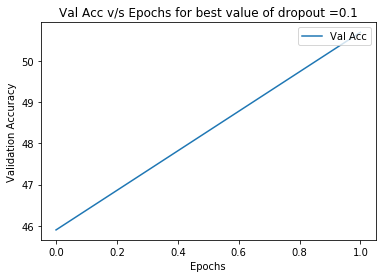

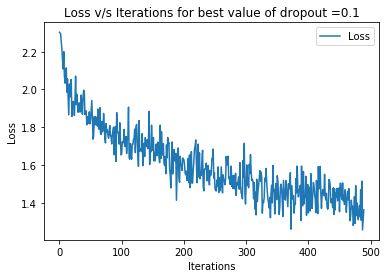

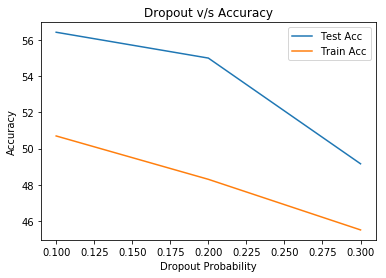

In [90]:
PosOfbestDropoutValue = np.argmax(testAcc)
plt.plot(listOfAllValAccs[PosOfbestDropoutValue], label = "Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.title('Val Acc v/s Epochs for best value of dropout ='+str(dropoutVals[PosOfbestDropoutValue]))
plt.legend(loc="upper right")
plt.show()

plt.plot(listOfAllLosses[PosOfbestDropoutValue], label = "Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title('Loss v/s Iterations for best value of dropout ='+str(dropoutVals[PosOfbestDropoutValue]))
plt.legend(loc="upper right")
plt.show()

plt.plot(dropoutVals, testAcc, label = "Test Acc")
plt.plot(dropoutVals, trainAcc, label = "Train Acc")
plt.xlabel("Dropout Probability")
plt.ylabel("Accuracy")
plt.title('Dropout v/s Accuracy')
plt.legend(loc="upper right")
plt.show()

In [91]:
modelBeforeTraining = ConvNet(input_size, hidden_size, num_classes, dropoutVals[PosOfbestDropoutValue]).to(device)
modelBeforeTraining.apply(weights_init)
print(model)
PrintModelSize(model)

ConvNet(
  (conv): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
    (4): Dropout2d(p=0.3)
    (5): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
    (9): Dropout2d(p=0.3)
    (10): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): ReLU()
    (14): Dropout2d(p=0.3)
    (15): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16):

7946506

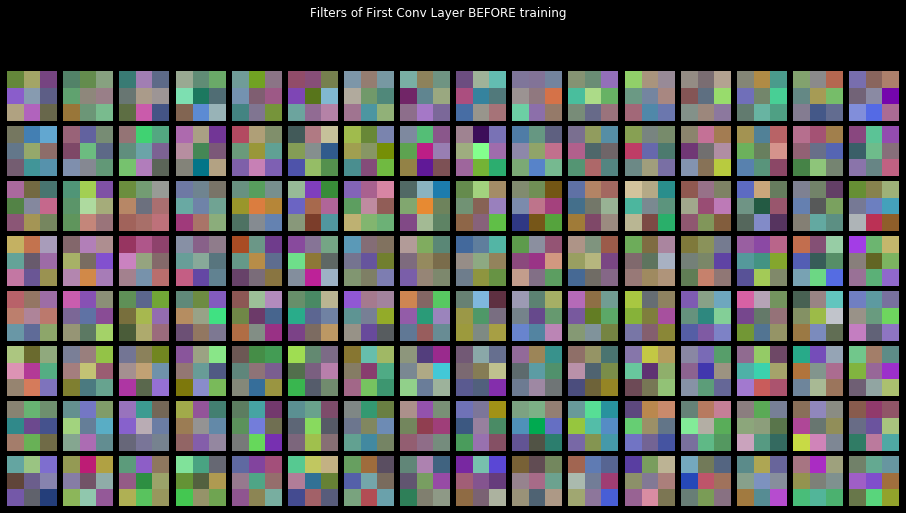

In [96]:
superTitle = 'Filters of First Conv Layer BEFORE training'
VisualizeFilter(modelBeforeTraining, superTitle)

In [97]:
bestDropoutModel = ConvNet(input_size, hidden_size, num_classes,  dropoutVals[PosOfbestDropoutValue]).to(device)
bestDropoutModel.load_state_dict(torch.load('CNN_models/bestESModel'+str(dropoutVals[PosOfbestDropoutValue])+'.ckpt'))

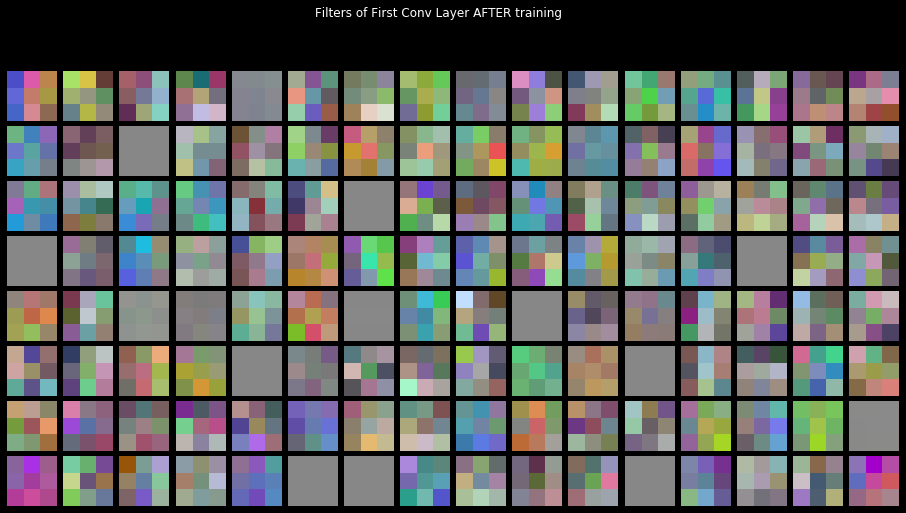

In [98]:
superTitle = 'Filters of First Conv Layer AFTER training'
VisualizeFilter(bestDropoutModel, superTitle)

In [123]:
def getLabels(dataset):
    labels = []
    for i in range(len(dataset)):
        labels.append(dataset[i][1])
    return labels

def run_testing_labels(model, test_loader):

    # Test the model
    with torch.no_grad():
        correct = 0
        total = 0
        allPredLabels = []
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _ , predicted = torch.max(outputs, 1)
            allPredLabels.append(predicted)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        testAcc = 100 * correct / total
        print('Accuracy of the network on the {} test images: {} %'.format(total, testAcc))
        
        return testAcc, allPredLabels
    
def display_classification_results(y_test, y_pred,title="Accuracy Heatmap",show_report=True):
    print("Test accuracy: %.2f%%"%(sklearn.metrics.accuracy_score(y_test, y_pred)*100))
    if show_report:
        print("Classification Report:\n",sklearn.metrics.classification_report(y_test, y_pred))
    plt.rcParams['figure.figsize'] = (10.0, 8.0)
    conf_mat = sklearn.metrics.confusion_matrix(y_test,y_pred)
    print("Confusion Matrix:\n",conf_mat)
    ax = sns.heatmap(conf_mat);
    ax.set(title=title, xlabel="CIFAR10 Classes", ylabel="CIFAR10 Classes")

In [124]:
testLabels = getLabels(test_dataset)

In [128]:
_, bestModelPreds = run_testing_labels(bestDropoutModel, test_loader)
bestModelPreds = [i.tolist() for i in bestModelPreds]
bestModelPreds = [item for sublist in bestModelPreds for item in sublist]

Accuracy of the network on the 10000 test images: 55.9 %


Test accuracy: 55.90%
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.57      0.60      1000
           1       0.69      0.80      0.74      1000
           2       0.40      0.30      0.34      1000
           3       0.32      0.24      0.28      1000
           4       0.46      0.40      0.42      1000
           5       0.49      0.51      0.50      1000
           6       0.60      0.68      0.64      1000
           7       0.54      0.67      0.59      1000
           8       0.67      0.73      0.70      1000
           9       0.66      0.70      0.68      1000

    accuracy                           0.56     10000
   macro avg       0.55      0.56      0.55     10000
weighted avg       0.55      0.56      0.55     10000

Confusion Matrix:
 [[569  54 126  24   4  14   6  14 151  38]
 [ 12 798   0  13   1   9  23   7  49  88]
 [ 78  16 305  93 193 100  92  68  31  24]
 [ 20  18  86 243  63 264 127 103  30  46]
 [ 3

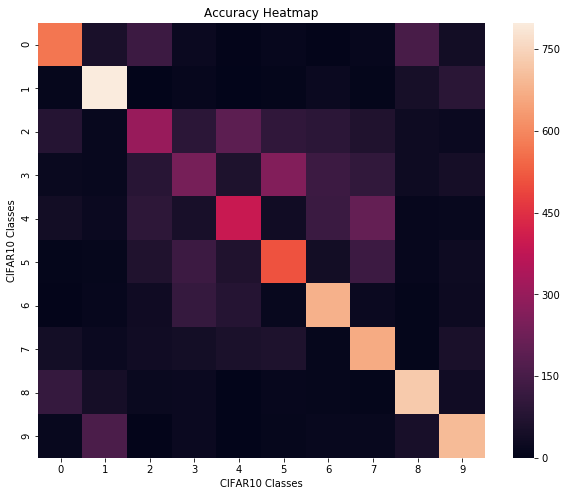

In [129]:
display_classification_results(testLabels, bestModelPreds, title="Accuracy Heatmap",show_report=True)